# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.2)

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    ## STUDENT START ###
    
    # creating dict to map train_label to train_label category
    train_label_dict = dict(zip(range(len(newsgroups_train.target_names)), newsgroups_train.target_names))

    # doing only for first 5 training examples
    for i in range(5):

        print(f'Example {i+1}')

        text = train_data[i].replace("\n"," ") # replace \n with space to make more readable
        label = train_label_dict.get(train_labels[i])
        print(f'\n Text: {text}')
        print(f'\n Label: {label} ({train_labels[i]})')
        print('\n\n')
    
    ## STUDENT END ###

P1(5)

Example 1

 Text: Hi,  I've noticed that if you only save a model (with all your mapping planes positioned carefully) to a .3DS file that when you reload it after restarting 3DS, they are given a default position and orientation.  But if you save to a .PRJ file their positions/orientation are preserved.  Does anyone know why this information is not stored in the .3DS file?  Nothing is explicitly said in the manual about saving texture rules in the .PRJ file.  I'd like to be able to read the texture rule information, does anyone have  the format for the .PRJ file?  Is the .CEL file format available from somewhere?  Rych

 Label: comp.graphics (1)



Example 2

 Text:   Seems to be, barring evidence to the contrary, that Koresh was simply another deranged fanatic who thought it neccessary to take a whole bunch of folks with him, children and all, to satisfy his delusional mania. Jim Jones, circa 1993.   Nope - fruitcakes like Koresh have been demonstrating such evil corruption for centur

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    ## STUDENT START ###
    
    ## transforming training data into a matrix of unigram feature vectors
    vect = CountVectorizer()
    X = vect.fit_transform(train_data)
    vocab = vect.get_feature_names() # already in alphabetical order
    X_matrix = X.toarray() # creating matrix of word unigram feature vectors
    print('Transforming training data into a matrix of unigram feature vectors:')
    print(f'Size of the vocabulary: {len(vocab)}')
    print(f'Average number of non-zero features per example: {round(X.nnz/len(X_matrix))}')
    print(f'Fraction of non-zero entries in the matrix: {X.nnz / X_matrix.size}')
    print(f'0th and last feature strings (in alphabetical order): {vocab[0]}, {vocab[-1]}')
    
    ## transforming the training data into a matrix of word unigram feature vectors with 
    ## vocab = ["atheism", "graphics", "space", "religion"]
    words = ["atheism", "graphics", "space", "religion"]
    vect2 = CountVectorizer(vocabulary = words)
    X2 = vect2.transform(train_data)
    X2_matrix = X2.toarray()
    print(f'\nTransforming training data into a matrix of word unigram features with vocabulary {words}:')
    print(f'Size of vocabulary: {len(vect2.get_feature_names())}')
    print(f'Average number of non-zero features per example: {X2.nnz/len(X2_matrix)}')
    
    ## transform training data into a matrix of character bigram and trigram feature vectors
    vect3 = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X3 = vect3.fit_transform(train_data)
    X3_matrix = X3.toarray()
    print('\nTransforming training data into a matrix of character bigram and trigram feature vectors:')
    print(f'Size of vocabulary: {len(vect3.get_feature_names())}')
    
    ## transform training data into a matrix of word unigram feature vectors and prune words 
    ## that appear in fewer than 10 documents
    vect4 = CountVectorizer(min_df=10)
    X4 = vect4.fit_transform(train_data)
    X4_matrix = X4.toarray()
    print('\nTransforming training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents:')
    print(f'Size of vocabulary: {len(vect4.get_feature_names())}')
    
    ## transform training data into a matrix of word unigram feature vectors
    vect = CountVectorizer()
    X = vect.fit_transform(train_data)
    train_vocab = vect.get_feature_names()
    X_dev = vect.fit_transform(dev_data)
    dev_vocab = vect.get_feature_names()
    print('\nTransforming training data into a matrix of word unigram feature vectors:')
    print(f'Fraction of words in dev vocab that is missing from train vocab: {(len(train_vocab)-len(dev_vocab))/len(train_vocab)}')
    
    ## STUDENT END ###

P2()

Transforming training data into a matrix of unigram feature vectors:
Size of the vocabulary: 26879
Average number of non-zero features per example: 97
Fraction of non-zero entries in the matrix: 0.0035978272269590263
0th and last feature strings (in alphabetical order): 00, zyxel

Transforming training data into a matrix of word unigram features with vocabulary ['atheism', 'graphics', 'space', 'religion']:
Size of vocabulary: 4
Average number of non-zero features per example: 0.26843657817109146

Transforming training data into a matrix of character bigram and trigram feature vectors:
Size of vocabulary: 35478

Transforming training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents:
Size of vocabulary: 3064

Transforming training data into a matrix of word unigram feature vectors:
Fraction of words in dev vocab that is missing from train vocab: 0.395587633468507


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():
    ## STUDENT START ###
    
    vect = CountVectorizer()
    X = vect.fit_transform(train_data)
    X_dev = vect.transform(dev_data)
    y = train_labels
    y_dev = dev_labels
    
    print('KNN\n')
    k_list = [1,5,10,20,50,100, 200, 500]
    best_k = 0
    max_f1 = 0
    for k in k_list:
        nn = KNeighborsClassifier(n_neighbors = k)
        nn.fit(X,y)
        y_pred = nn.predict(X_dev)
        f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
        print(f'K = {k}')
        print(f'f1 score = {f1_score}')
        if f1_score > max_f1:
            max_f1 = f1_score
            best_k = k
    
    print('\n')
    print(f'Best k: {best_k}')
    print(f'Best f1 score: {max_f1}')
    print('\n\n')
    
    
    print('MNB\n')
    alpha_list = [1e-9, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    best_alpha = 0
    max_f1 = 0
    for alpha in alpha_list:
        mnb = MultinomialNB(alpha = alpha)
        mnb.fit(X,y)
        y_pred = mnb.predict(X_dev)
        f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
        print(f'Alpha = {alpha}')
        print(f'f1 score = {f1_score}')
        if f1_score > max_f1:
            max_f1 = f1_score
            best_alpha = alpha
    
    print('\n')
    print(f'Best alpha: {best_alpha}')
    print(f'Best f1 score: {max_f1}')
    print('\n\n')
    
    
    print('Logistic Regression\n')
    c_list = [1e-9, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    best_c = 0
    max_f1 = 0
    for c in c_list:
        lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        lr.fit(X,y)
        y_pred = lr.predict(X_dev)
        f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
        print(f'C = {c}')
        print(f'f1 score = {f1_score}')
        print(f'sum of squared weights = {[sum(x) for x in lr.coef_]}')
        if f1_score > max_f1:
            max_f1 = f1_score
            best_c = c
    
    print('\n')
    print(f'Best k: {best_c}')
    print(f'Best f1 score: {max_f1}')

    
    ## STUDENT END ###

P3()

KNN

K = 1
f1 score = 0.3805030018531525
K = 5
f1 score = 0.4287607236218357
K = 10
f1 score = 0.4278502905941064
K = 20
f1 score = 0.4243419588207676
K = 50
f1 score = 0.4176318433511905
K = 100
f1 score = 0.4422400339224965
K = 200
f1 score = 0.4180556621195381


/Users/julielai/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/julielai/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K = 500
f1 score = 0.3336418826736761


Best k: 100
Best f1 score: 0.4422400339224965



MNB

Alpha = 1e-09
f1 score = 0.7490691140139345
Alpha = 0.0001
f1 score = 0.7628348704826354
Alpha = 0.001
f1 score = 0.7702518836155706
Alpha = 0.01
f1 score = 0.7751663218544357
Alpha = 0.1
f1 score = 0.7903052385098862
Alpha = 1
f1 score = 0.7777320236017224
Alpha = 10
f1 score = 0.6674814338256576
Alpha = 100
f1 score = 0.5100896536573467


Best alpha: 0.1
Best f1 score: 0.7903052385098862



Logistic Regression

C = 1e-09
f1 score = 0.20641155283594254
sum of squared weights = [-9.890227909355074e-05, -9.859058862783266e-05, -7.156624981414998e-05, -0.00010773262544659637]
C = 0.0001
f1 score = 0.5416003218838589
sum of squared weights = [-0.8783688467852708, 0.016723680771412754, -0.18979806307832514, -1.0982652410227838]
C = 0.001
f1 score = 0.6193046812006844
sum of squared weights = [-3.4809448354459476, -0.44880382450754747, -0.33424933295491854, -4.091916868671586]
C = 0.01
f1 score = 0

ANSWER: 

K-Nearest Neighbors doesn't work well for this problem because it does not work well for high dimensional data. The "curse of dimensionality" is a way to describe the problem of the size of the data growing exponentially with the number of features/dimensions. K-Nearest Neighbors is especially sensitive to this problem because it requires every point to be close to every axis in the data space. As each feature is added, it becomes harder for two specific points to be close to each other on every single axis. 

In Naive Bayes, you set each feature's weight independently, based on how much it correlates with the label. In Logistic Regression, you set all the weights together such that the linear decision function tends to be high for positive classes and low for negative classes. Logistic Regression doesn't work as well as Naive Bayes does because when you have correlated, repetitive features, Naive Bayes will give both of them strong weights so their influence is double-counted whereas Logistic Regression will compensate by weighting them lower.

The relationship between logistic regression's sum of squared weights vs. C value is that the C value (regularization) avoids learning very large weights by adding a penalty to the total size of the learned weights. The default L2 regularization computes this size as the sum of the squared weights. This makes all the weights relatively small. 


### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4():
    ## STUDENT START ###
    
    # transform data into word bigram feature vectors
    vect_bi = CountVectorizer(analyzer='word', ngram_range=(2,2))
    train_bi = vect_bi.fit_transform(train_data)
    train_bi_matrix = train_bi.toarray()
    
    # producing a logistic regression model
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(train_bi, train_labels)
    
    # sorting each weight from lowest to highest and getting the indexes 
    ind = np.argsort(lr.coef_)
    
    # getting weights of all the top 5 features for all topics
    all_max_weights = []
    for i in range(4):
        max_weights = lr.coef_[i][ind[:,-5:]].flatten()
        all_max_weights.append(max_weights)
        
    # getting all top 5 feature names per topic
    feat_list = []
    for i in range(4):
        index = ind[:,-5:][i]
        for j in index:
            max_features = vect_bi.get_feature_names()[j]
            feat_list.append(max_features)
    
    # 20 row (features) x 4 column (topics) table of the weights
    feat_weight_table = pd.DataFrame(all_max_weights, index = newsgroups_train.target_names, columns = feat_list).T
    print(feat_weight_table)

    
    ## STUDENT END ###

P4()

               alt.atheism  comp.graphics  sci.space  talk.religion.misc
are you           0.446954      -0.248257  -0.097166           -0.305622
you are           0.472741      -0.279913  -0.481426            0.028367
was just          0.482050      -0.131419  -0.128862           -0.227465
cheers kent       0.555719      -0.697903  -0.663776            0.534812
claim that        0.605549      -0.199042  -0.274383           -0.140369
is there         -0.340882       0.754978  -0.468250           -0.257080
out there        -0.274802       0.758683  -0.479004           -0.277087
comp graphics    -0.292166       0.801202  -0.370919           -0.285185
in advance       -0.459351       0.832568  -0.438488           -0.418455
looking for      -0.630341       1.108366  -0.499926           -0.571863
it was           -0.203030      -0.309663   0.525345           -0.313554
and such         -0.204269      -0.337521   0.590560           -0.218199
sci space        -0.258008      -0.329149   0.62113

ANSWER: Some of the interesting features that stand out to me are 'cheers kent', 'sci space', 'of jesus', and 'the fbi' because they're fairly specific compare to common phrases like 'are you' and 'is there'. 'Cheers kent' is particularly suprising because it seems like an oddly specific phrase yet it comes up twice as an important feature

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [12]:
def better_preprocessor(s):
    ## STUDENT START ###

    # removing various non-letter characters and replacing with space
    regex = re.compile('[,\/.!?)(]')
    new_str = regex.sub(' ', s.lower()) # making sure string is lowercase
    # replacing strings of numbers with token 'X'
    regex = re.compile('[0-9]')
    new_str = regex.sub('X', new_str) 
    new_str = new_str.split()    
    short_str = []
    for word in new_str:
        if len(word) > 3: # removing short words
             short_str.append(word[:5]) # shortening words
    return ' '.join(short_str)
    
    ## STUDENT END ###
    
def empty_preprocessor(s):
    return s

def P5():
    ## STUDENT START ###
    
    # before preprocessing of text
    vect = CountVectorizer(preprocessor = empty_preprocessor)
    X_train = vect.fit_transform(train_data)
    X_dev = vect.transform(dev_data)
    y_dev = dev_labels

    # producing a logistic regression model
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)

    y_pred = lr.predict(X_dev)
    f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
    vocab_size = len(vect.get_feature_names())

    print('No Preprocessing of Text')
    print(f'F1 Score: {f1_score}')
    print(f'Size of vocabulary: {vocab_size}')
    
    # preprocessing text
    vect5 = CountVectorizer(preprocessor = better_preprocessor)
    train_5 = vect5.fit_transform(train_data)
    X_dev5 = vect5.transform(dev_data)
    y_dev = dev_labels

    # producing a logistic regression model
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(train_5, train_labels)

    y_pred = lr.predict(X_dev5)
    f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
    vocab_size2 = len(vect5.get_feature_names())
    
    print('\nAfter Preprocessing Text')
    print(f'F1 Score: {f1_score}')
    print(f'Size of vocabulary: {vocab_size2}')    
    
    print(f'\nThe improved model reduced the vocabulary size by {vocab_size - vocab_size2} words')
    
    ## STUDENT END ###

P5()

No Preprocessing of Text
F1 Score: 0.7069109185493502
Size of vocabulary: 33291

After Preprocessing Text
F1 Score: 0.7329300605986178
Size of vocabulary: 14323

The improved model reduced the vocabulary size by 18968 words


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

F1 score of model based on full vocabulary: 0.7167488507823554


/Users/julielai/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


L1 regularization strength: 0.001
Vocabulary Size: 1
F1 score: 0.2798871977452254


L1 regularization strength: 0.1
Vocabulary Size: 190
F1 score: 0.6706398814068231


L1 regularization strength: 0.5
Vocabulary Size: 715
F1 score: 0.7042672321962207


L1 regularization strength: 1
Vocabulary Size: 1062
F1 score: 0.6897775807933507


L1 regularization strength: 5
Vocabulary Size: 2086
F1 score: 0.7082720055384313


L1 regularization strength: 10
Vocabulary Size: 2868
F1 score: 0.711574351448002


L1 regularization strength: 20
Vocabulary Size: 3705
F1 score: 0.7300256665454736


L1 regularization strength: 50
Vocabulary Size: 4925
F1 score: 0.7143987751095205


L1 regularization strength: 100
Vocabulary Size: 5836
F1 score: 0.7137317828674999




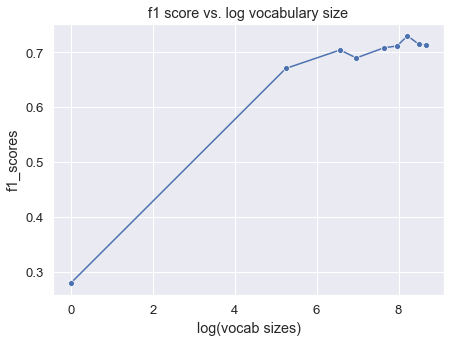

In [13]:
def P6():
#     Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ## STUDENT START ###
    
    C_list = [0.001, 0.1, 0.5, 1, 5, 10, 20, 50, 100]

    # preprocessing text
    vect6 = CountVectorizer(preprocessor = better_preprocessor)
    train_6 = vect6.fit_transform(train_data)
    X_dev6 = vect6.transform(dev_data)
    y_dev = dev_labels
    
    # producing a logistic regression model based on full vocabulary
    lr2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015)
    lr2.fit(train_6, train_labels)
    y_pred = lr2.predict(X_dev6)
    f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
    print(f'F1 score of model based on full vocabulary: {f1_score}')

    vocab_sizes = []
    f1_scores = []
    for c in C_list:

        # producing a logistic regression model
        lr1 = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
        lr1.fit(train_6, train_labels)
        y_pred = lr1.predict(X_dev6)
        weights = lr1.coef_.T # transpose so that each row is a feature

        nonzero_feature_index = []
        for feature_index in range(len(weights)):
            if np.mean(weights[feature_index]) != 0: # if mean > 0 there is at least one non-zero weight among the four categories
                nonzero_feature_index.append(feature_index)

        # getting vocab at least one non-zero weight among the four categories
        vocab = []
        for index in nonzero_feature_index:
            vocab.append(vect6.get_feature_names()[index])
        vocab_sizes.append(len(vocab))

        # preprocessing text and reducing vocabulary
        vect6a = CountVectorizer(preprocessor = better_preprocessor, vocabulary = vocab)
        train_6a = vect6a.fit_transform(train_data)
        X_dev6a = vect6a.transform(dev_data)
        y_dev = dev_labels

        # producing a logistic regression model
        lr2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015)
        lr2.fit(train_6a, train_labels)

        y_pred = lr2.predict(X_dev6a)
        f1_score2 = metrics.f1_score(y_dev, y_pred, average="weighted")
        f1_scores.append(f1_score2)

        print(f"L1 regularization strength: {c}")
        print(f"Vocabulary Size: {len(vocab)}")
        print(f"F1 score: {f1_score2}")
        print("\n")
        
    # Show a plot of f1 score vs. log vocabulary size.
    plt.figure(figsize=(7,5))
    sns.lineplot(np.log(vocab_sizes),f1_scores, marker='o')
    plt.xlabel('log(vocab sizes)')
    plt.ylabel('f1_scores')
    plt.title('f1 score vs. log vocabulary size')
    
    ## STUDENT END ###

P6()

ANSWER: 
The f1 score of a model based on the full vocabulary is 0.717. The models based on reduced vocabularies don't do as well although they begin to inch closer to the f1 score of 0.717 at a vocabulary size of 2868 with an f1 score of 0.712. At a vocabulary size of 3705, the f1 score peaks at around 0.730. From there the f1 score dips slightly to around 0.714 and 0.713 with vocabulary sizes of 4925 and 5836 respectively.
 

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [14]:
def P7():
    ## STUDENT START ###
    
    np.random.seed(0)
    
    tfidf = TfidfVectorizer()
    tfidf_train = tfidf.fit_transform(train_data)
    X_dev = tfidf.transform(dev_data)
    y_dev = dev_labels
    
    # producing a logistic regression model
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
    lr.fit(tfidf_train, train_labels)
    y_pred = lr.predict(X_dev)
    f1_score = metrics.f1_score(y_dev, y_pred, average="weighted")
    print(f'f1 score: {f1_score} \n\n')
    
    # finding r score
    # r score = max predicted probability / predicted probability of correct label
    probs = lr.predict_proba(X_dev)
    r_scores = []
    for index in range(len(probs)):
        correct_index = y_dev[index]
        r_score = max(probs[index])/probs[index][correct_index]
        r_scores.append(r_score)
        
    # showing the 3 documents with highest R ratio
    max3_ind = np.argsort(r_scores)[-3:]
    
    # creating dict to map dev_label to label category
    label_dict = dict(zip(range(len(newsgroups_train.target_names)), newsgroups_train.target_names))
    
    for ind in max3_ind:
        print(f'R ratio: {r_scores[ind]}')
        print(dev_data[ind])
        print(f'Predicted Label: {label_dict.get(y_pred[ind])}')
        print(f'Actual Label: {tlabel_dict.get(dev_labels[ind])}')
        print(f'\n')

    
    ## STUDENT END ###

P7()

f1 score: 0.7429918959090186 


R ratio: 2279.7393432682297
With the Southern Baptist Convention convening this June to consider
the charges that Freemasonry is incompatible with christianity, I thought
the following quotes by Mr. James Holly, the Anti-Masonic Flag Carrier,
would amuse you all...

     The following passages are exact quotes from "The Southern 
Baptist Convention and Freemasonry" by James L. Holly, M.D., President
of Mission and Ministry To Men, Inc., 550 N 10th St., Beaumont, TX 
77706. 
 
     The inside cover of the book states: "Mission & Ministry to Men, 
Inc. hereby grants permission for the reproduction of part or all of 
this booklet with two provisions: one, the material is not changed and
two, the source is identified." I have followed these provisions. 
  
     "Freemasonry is one of the allies of the Devil" Page iv. 
 
     "The issue here is not moderate or conservative, the issue is God
and the Devil" Page vi." 
 
     "It is worthwhile to remember that t

NameError: name 'tlabel_dict' is not defined

ANSWER:


TfidfVectorizer() returns floats while the CountVectorizer() returns ints. CountVectorizer() returns counts whereas TfidfVectorizer() returns a score of term-frequency times inverse document-frequency
In simplistic tf-idf means term-frequency (how often the word appears in the document) times inverse document-frequency (how often the term appears across all documents in the data set). This means words like 'a' and 'the' will have low scores as they are common words. In CountVectorizer(), common words like 'a' and 'the' will have higher weighs because they show up more. 

The R ratio describes how wrong the model was for a document. The lowest R ratio value you can get is 1, meaning that the predicted label is the same as the correct label. The higher the predicted label probability is, means the lower the probability of the correct probability is (because the sum of the predicted probabilities for all 4 labels must equal 1). In other words, a higher predicted label probability means a stronger confidence in the predicted label. Therefore a high R ratio means a very strong confidence in the predicted label and very little confidence in the correct label.

A mistake I see is misspelling. There are several misspelled words in the data set and since tf-idf reward rare words, an issue might be giving a higher weight to mispelled words over the correctly spelled word that is used more often. In order to address this might be breaking the document into sentences rather than words (unigrams) or (bigrams) so that the sentence as a whole provides some context to the document and there is less emphasis put on each individual word.




### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.